## Imports

In [1]:
import tensorflow as tf
from glob import glob
from os.path import join
from tensorflow.keras import layers, models
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imports.GDL_layers as GDL_layers
from imports.GDL_model import gdl_model, CNN_model
import copy, gc
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler

2023-01-04 09:37:25.246704: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load Data

In [2]:
ev_ds = xr.open_dataset('data/ev_ds.nc')

In [3]:
ev_ds

<xarray.Dataset>
Dimensions:                 (model: 6, test_sample: 6236, maj_min: 2)
Coordinates:
  * model                   (model) int64 0 1 2 3 4 5
  * test_sample             (test_sample) int64 0 1 2 3 ... 6232 6233 6234 6235
  * maj_min                 (maj_min) object 'major axis' 'minor axis'
Data variables:
    cnn_ensemble_mu         (model, test_sample, maj_min) float64 ...
    cnn_ensemble_sigma      (model, test_sample, maj_min) float64 ...
    aug_cnn_ensemble_mu     (model, test_sample, maj_min) float64 ...
    aug_cnn_ensemble_sigma  (model, test_sample, maj_min) float64 ...

In [2]:
r_ev_ds = xr.open_dataset('data/ev_ds.nc')

In [3]:
r_ev_ds

<xarray.Dataset>
Dimensions:                 (model: 6, test_sample: 6236, maj_min: 2)
Coordinates:
  * model                   (model) int64 0 1 2 3 4 5
  * test_sample             (test_sample) int64 0 1 2 3 ... 6232 6233 6234 6235
  * maj_min                 (maj_min) object 'major axis' 'minor axis'
Data variables:
    cnn_ensemble_mu         (model, test_sample, maj_min) float64 ...
    cnn_ensemble_sigma      (model, test_sample, maj_min) float64 ...
    aug_cnn_ensemble_mu     (model, test_sample, maj_min) float64 ...
    aug_cnn_ensemble_sigma  (model, test_sample, maj_min) float64 ...

## CNN Ensemble of Ensembles

In [4]:
cnn_aleatoric = np.mean(ev_ds['cnn_ensemble_sigma'], 0)
cnn_epistemic = np.var(ev_ds['cnn_ensemble_mu'], 0)

In [5]:
print(cnn_epistemic.mean() ** (1/2), cnn_aleatoric.mean() ** (1/2))

<xarray.DataArray 'cnn_ensemble_mu' ()>
array(1.31397373) <xarray.DataArray 'cnn_ensemble_sigma' ()>
array(3.37377368)


In [13]:
print(cnn_epistemic.mean() ** (1/2), cnn_aleatoric.mean() ** (1/2))

1.391468362131906 3.231671167603971


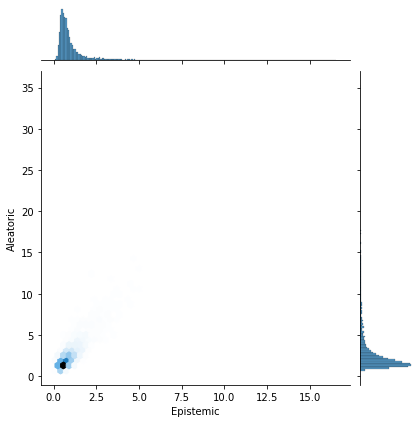

In [6]:
sns.jointplot(x = np.sqrt(cnn_epistemic[:, 0]), y = np.sqrt(cnn_aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Epistemic')
plt.ylabel('Aleatoric')
plt.show()

## Augmented CNN Ensemble of Ensembles

In [7]:
aug_cnn_aleatoric = np.mean(ev_ds['aug_cnn_ensemble_sigma'], 0)
aug_cnn_epistemic = np.var(ev_ds['aug_cnn_ensemble_mu'], 0)

In [8]:
print(aug_cnn_epistemic.mean() ** (1/2), aug_cnn_aleatoric.mean() ** (1/2))

<xarray.DataArray 'aug_cnn_ensemble_mu' ()>
array(1.13742365) <xarray.DataArray 'aug_cnn_ensemble_sigma' ()>
array(2.77485092)


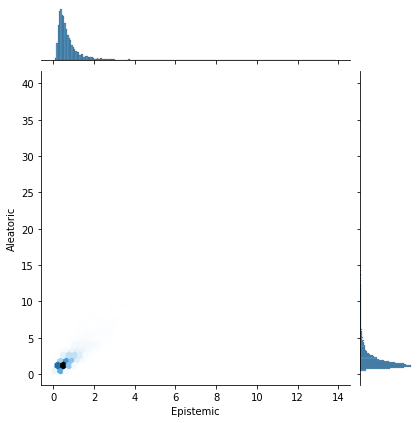

In [9]:
sns.jointplot(x = np.sqrt(aug_cnn_epistemic[:, 0]), y = np.sqrt(aug_cnn_aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Epistemic')
plt.ylabel('Aleatoric')
plt.show()

In [12]:
def aug_array(arr, rot=True):
    length = arr.shape[0]
    aug_arr = np.concatenate([arr]*4, axis=0)
    if rot:
        for k in range(4):
            aug_arr[k*length:(k+1)*length] = np.rot90(aug_arr[k*length:(k+1)*length], axes=(1, 2), k=k)
    return aug_arr

In [ ]:
aug_cnn_ensemble_mu = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))
aug_cnn_ensemble_sigma = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))

for model_seed in range(n_models):
    
    _model = CNN_model(
        filters=[32, 32, 64, 64, 128],
        kernel_sizes=[3, 3, 3, 3, 3],
        conv_2d_activation='relu',
        pool_sizes=[2, 2, 2, 2, 1],
        dense_activation='relu',
        lr=0.000628345,
        optimizer='nadam',
        metrics=[],
        batch_size=19,
        epochs=10
    )
    _ensemble_pred = np.zeros((n_splits, input_test['REFL_COM_curr'].shape[0], 2))
    
    for data_seed in range(n_splits):
        
        gsp = GroupShuffleSplit(n_splits=n_splits, random_state = flat_seed, train_size=0.885)
        splits = list(gsp.split(input_train_full["REFL_COM_curr"], groups=input_train_full['date']))
        train_index, val_index = splits[data_seed]
        input_train, input_val = input_train_full.isel(p=train_index), input_train_full.isel(p=val_index)
        output_train, output_val = output_train_full.isel(p=train_index), output_train_full.isel(p=val_index)
        
        x_scaler, y_scaler = ImageScaler(), StandardScaler()
        input_train_norm = x_scaler.fit_transform(input_train["REFL_COM_curr"].values)
        input_val_norm = x_scaler.transform(input_val["REFL_COM_curr"].values)
        input_test_norm = x_scaler.transform(input_test["REFL_COM_curr"].values)
        
        output_train_norm = y_scaler.fit_transform(output_train.values)
        output_val_norm = y_scaler.transform(output_val.values)
        output_test_norm = y_scaler.transform(output_test.values)
        
        aug_input_train_norm = aug_array(input_train_norm)
        aug_output_train_norm = aug_array(output_train_norm, rot=False)
        
        model = copy.deepcopy(_model)
        
        history = model.fit(
            x = aug_input_train_norm,
            y = aug_output_train_norm,
            xv = input_val_norm,
            yv = output_val_norm
        )
        
        _ensemble_pred[data_seed] = y_scaler.inverse_transform(model.predict(input_test_norm))
        
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        
    aug_cnn_ensemble_mu[model_seed] = np.mean(_ensemble_pred, 0)
    aug_cnn_ensemble_sigma[model_seed] = np.var(_ensemble_pred, 0)

  1/195 [..............................] - ETA: 19s

In [ ]:
aug_cnn_aleatoric = np.mean(aug_cnn_ensemble_sigma, 0)
aug_cnn_epistemic = np.var(aug_cnn_ensemble_mu, 0)

In [ ]:
print(aug_cnn_epistemic.mean() ** (1/2), aug_cnn_aleatoric.mean() ** (1/2))

In [ ]:
sns.jointplot(x = np.sqrt(aug_cnn_epistemic[:, 0]), y = np.sqrt(aug_cnn_aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Epistemic')
plt.ylabel('Aleatoric')
plt.show()

In [ ]:
ricnn_ensemble_mu = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))
ricnn_ensemble_sigma = np.zeros((n_models, input_test['REFL_COM_curr'].shape[0], 2))

for model_seed in range(n_models):
    
    _model = gdl_model(
        filters=[32, 32, 64, 64, 128],
        kernel_sizes=[3, 3, 3, 3, 3],
        conv_2d_activation='relu',
        pool_sizes=[2, 2, 2, 2, 1],
        dense_activation='relu',
        rot_inv=4,
        lr=0.000628345,
        optimizer='nadam',
        metrics=[],"
        batch_size=19,
        epochs=10
    )
    _ensemble_pred = np.zeros((n_splits, input_test['REFL_COM_curr'].shape[0], 2))
    
    for data_seed in range(n_splits):
        
        gsp = GroupShuffleSplit(n_splits=n_splits, random_state = flat_seed, train_size=0.885)
        splits = list(gsp.split(input_train_full["REFL_COM_curr"], groups=input_train_full['date']))
        train_index, val_index = splits[data_seed]
        input_train, input_val = input_train_full.isel(p=train_index), input_train_full.isel(p=val_index)
        output_train, output_val = output_train_full.isel(p=train_index), output_train_full.isel(p=val_index)
        
        x_scaler, y_scaler = ImagedScaler(), StandardScaler()
        input_train_norm = x_scaler.fit_transform(input_train["REFL_COM_curr"])
        input_val_norm = x_scaler.transform(input_val["REFL_COM_curr"])
        input_test_norm = x_scaler.transform(input_test["REFL_COM_curr"])
        
        output_train_norm = y_scaler.fit_transform(output_train)
        output_val_norm = y_scaler.transform(output_val)
        output_test_norm = y_scaler.transform(output_test)
        
        model = copy.deepcopy(_model)
        
        history = model.fit(
            x = input_train_norm,
            y = output_train_norm,
            xv = input_val_norm,
            yv = output_val_norm
        )
        
        _ensemble_pred[data_seed] = y_scaler.inverse_transform(model.predict(input_test_norm))
        
        del model
        tf.keras.backend.clear_session()
        gc.collect()
        
    ricnn_ensemble_mu[model_seed] = np.mean(_ensemble_pred, 0)
    ricnn_ensemble_sigma[model_seed] = np.var(_ensemble_pred, 0)

In [ ]:
ricnn_aleatoric = np.mean(ricnn_ensemble_sigma, 0)
ricnn_epistemic = np.var(ricnn_ensemble_mu, 0)

In [ ]:
print(ricnn_epistemic.mean() ** (1/2), ricnn_aleatoric.mean() ** (1/2))

In [ ]:
sns.jointplot(x = np.sqrt(ricnn_epistemic[:, 0]), y = np.sqrt(ricnn_aleatoric[:, 0]), kind = 'hex')
plt.xlabel('Epistemic')
plt.ylabel('Aleatoric')
plt.show()